Iniciando o código importando as principais bibliotecas usadas no projeto:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

Importando o arquivo .csv com o pandas, e salvando na variável data_set:

In [2]:
data_set = pd.read_csv('fetal_health.csv')

Verificando se há dados faltantes na base de dados, o que não ocorreu:

In [3]:
data_set.isnull().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

Analisando a correlação dos atributos com a classes:

<AxesSubplot:>

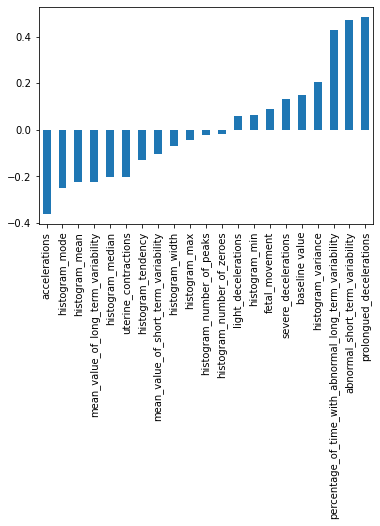

In [4]:
data_set.corr()['fetal_health'][:-1].sort_values().plot(kind='bar')

Aprofundando a análise de correlação, é plotado o um heatmap da correlação entre os atributos.
A análise indica que há alguns atributos bastante independentes (correlação negativa), o que é um indicativo de bons resultados na classificação. Há outros atributos que não tão independentes, mas foi decidido utilizar todos os atributos originais da base de dados.

<AxesSubplot:>

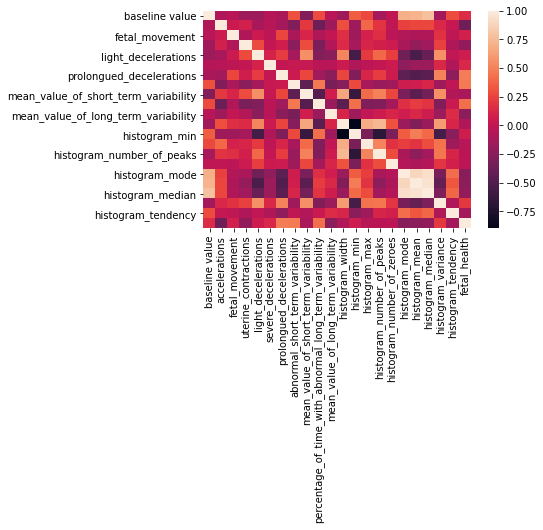

In [5]:
sns.heatmap(data_set.corr())

Verificando se as classes da base são balanceadas. A partir do gráfico, é possível verificar que as bases são bastante desbalanceadas, o que prejudicaria a classificação das demais.

<AxesSubplot:xlabel='fetal_health', ylabel='count'>

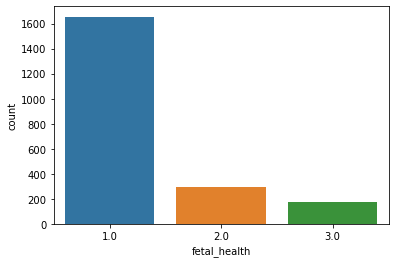

In [6]:
sns.countplot(x='fetal_health', data=data_set)

Separando os atributos e as classes em variáveis diferentes, em que X = atributos, e Y = classes.

In [7]:
X = data_set.drop('fetal_health', axis=1).values
Y = data_set['fetal_health'].values

Para solucionar o problema do desbalanceamento das classes, foi escolhido o método SMOTE para oversampling, que utiliza a interpolação para gerar novas instâncias sintéticas.
Em seguida, é plotado novamente a contagem das classes para verificar que estão balanceadas.

<AxesSubplot:ylabel='count'>

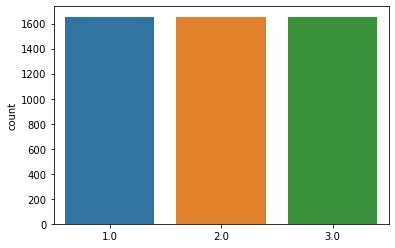

In [8]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=13)
X, Y = sm.fit_resample(X, Y)
sns.countplot(x=Y)

Na primeira parte do processo de classificação foi feita uma busca exaustiva a partir do método GridSearchCV, que busca os melhores resultados dentre uma gama de parâmetros passados ao método.

Quanto maior a quantidade de parâmetros, estimators, kernels, gammas, mais combinações possíveis são testadas para encontrar a melhor possível.

Por motivos de complexidade e custo computacional, os parâmetros escolhidos foram limitados a: máquina de vetor suporte (SVM) como estimator, os kernels linear e rbf, com parâmetros C = [1, 10, 20] e gamma = [0.1, 0.01, 0.001]

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
parameters= [
  {'C': [1, 10, 20], 'kernel': ['linear']},
  {'C': [1, 10, 20], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
 ]
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, verbose=1)
clf.fit(X,Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 16.4min finished


GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 20], 'kernel': ['linear']},
                         {'C': [1, 10, 20], 'gamma': [0.1, 0.01, 0.001],
                          'kernel': ['rbf']}],
             verbose=1)

A melhor combinação de parâmetros achada foi:

In [10]:
clf.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Que obteve acurácia média de:

In [12]:
clf.best_score_

0.9603222557905339

Nessa primeira parte, foi utilizada apenas a métrica de acurácia para uma rápida avaliação da performance do método.
Os outros tipos de métricas serão abordados na segunda parte, que utiliza deep learning.


* INICIO DA PARTE DE DEEP LEARNING 

Como a base de dados é multi-classes, a primeira coisa a se fazer foi transformar a coluna de classes para o formato (n_samples, n_classes), com valores binários. Para isso, foi utilizado o método seguinte:

In [13]:
lb = preprocessing.LabelBinarizer()
Y = lb.fit_transform(Y)

Em seguida, os conjuntos de treino e teste foram divididos utilizando validação percentual de 30%

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=97)

Foram testados métodos de padronização dos dados, e o que teve melhor desempenho foi o StandardScaler, por isso foi o escolhido para dar continuidade aos experimentos.

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = MinMaxScaler()
scaler =StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Para construção da rede profunda, foi escolhido o modelo sequencial, com camadas densas e dropout para diminuir a chance de overfitting.
Como a base é multi-classes, na última camada foram colocados 3 neurônios (número de classes), e com função de ativação softmax, e nas demais a relu.
A função perda escolhida foi a 'categorical_crossentropy' que é usada para bases multi-classes. Foi escolhido o otimizador adam, pois estudos mostram um melhor desempenho que os demais.

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()

model.add(Dense(21, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(40, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(20, activation='relu'))
model.add(Dropout(0.15))

model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

Configuração dos critérios de parada no processo de treinamento:

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=45)

Passando os dados de treino para o modelo, e utilizando os dados de teste como dados de validação do modelo.

In [18]:
model.fit(x=X_train, y=y_train, epochs = 500, validation_data=(X_test,y_test), callbacks=[early_stop])

Train on 3475 samples, validate on 1490 samples
Epoch 1/500
3475/3475 [==============================] - 1s 365us/sample - loss: 0.8883 - val_loss: 0.5221
Epoch 2/500
3475/3475 [==============================] - 0s 93us/sample - loss: 0.5405 - val_loss: 0.3610
Epoch 3/500
3475/3475 [==============================] - 0s 89us/sample - loss: 0.4456 - val_loss: 0.3118
Epoch 4/500
3475/3475 [==============================] - 0s 88us/sample - loss: 0.4075 - val_loss: 0.3003
Epoch 5/500
3475/3475 [==============================] - 0s 89us/sample - loss: 0.3761 - val_loss: 0.2747
Epoch 6/500
3475/3475 [==============================] - 0s 87us/sample - loss: 0.3512 - val_loss: 0.2614
Epoch 7/500
3475/3475 [==============================] - 0s 92us/sample - loss: 0.3368 - val_loss: 0.2580
Epoch 8/500
3475/3475 [==============================] - 0s 89us/sample - loss: 0.3164 - val_loss: 0.2402
Epoch 9/500
3475/3475 [==============================] - 0s 86us/sample - loss: 0.2996 - val_loss: 0.23

3475/3475 [==============================] - 0s 94us/sample - loss: 0.1237 - val_loss: 0.1051
Epoch 78/500
3475/3475 [==============================] - 0s 85us/sample - loss: 0.1284 - val_loss: 0.1019
Epoch 79/500
3475/3475 [==============================] - 0s 88us/sample - loss: 0.1195 - val_loss: 0.1072
Epoch 80/500
3475/3475 [==============================] - 0s 93us/sample - loss: 0.1252 - val_loss: 0.0967
Epoch 81/500
3475/3475 [==============================] - 0s 88us/sample - loss: 0.1263 - val_loss: 0.0997
Epoch 82/500
3475/3475 [==============================] - 0s 93us/sample - loss: 0.1325 - val_loss: 0.1030
Epoch 83/500
3475/3475 [==============================] - 0s 89us/sample - loss: 0.1202 - val_loss: 0.1073
Epoch 84/500
3475/3475 [==============================] - 0s 84us/sample - loss: 0.1132 - val_loss: 0.0965
Epoch 85/500
3475/3475 [==============================] - 0s 85us/sample - loss: 0.1136 - val_loss: 0.0990
Epoch 86/500
3475/3475 [==========================

3475/3475 [==============================] - 0s 89us/sample - loss: 0.0938 - val_loss: 0.0856
Epoch 154/500
3475/3475 [==============================] - 0s 95us/sample - loss: 0.0943 - val_loss: 0.0985
Epoch 155/500
3475/3475 [==============================] - 0s 85us/sample - loss: 0.0947 - val_loss: 0.0970
Epoch 156/500
3475/3475 [==============================] - 0s 97us/sample - loss: 0.0996 - val_loss: 0.0968
Epoch 157/500
3475/3475 [==============================] - 0s 86us/sample - loss: 0.0917 - val_loss: 0.0936
Epoch 158/500
3475/3475 [==============================] - 0s 99us/sample - loss: 0.0934 - val_loss: 0.0870
Epoch 159/500
3475/3475 [==============================] - 0s 85us/sample - loss: 0.0907 - val_loss: 0.0965
Epoch 160/500
3475/3475 [==============================] - 0s 96us/sample - loss: 0.0896 - val_loss: 0.0922
Epoch 161/500
3475/3475 [==============================] - 0s 85us/sample - loss: 0.1014 - val_loss: 0.0873
Epoch 162/500
3475/3475 [=================

A configuração de parada interrompeu o processo no Epoch 216/500.

Em seguida, é plotado o histórico da função perda, comparando os dados de treino e de validação. 
É possível observar que não houve overfitting.

<AxesSubplot:>

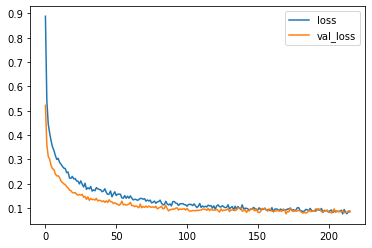

In [19]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

Utilizando o modelo treinado para classificar o conjunto de teste:

In [20]:
predic = model.predict_classes(X_test)

Declarando algumas variáveis para a realização do cálculo das métricas sem a utilizando de bibliotecas:

patologico_total, suspeito_total e normal_total guardam a quantidade das respectivas classes no conjunto de teste.

In [22]:
import collections
y_aux = y_test
y_aux = lb.inverse_transform(y_aux)
patologico_total = collections.Counter(y_aux)[3]
suspeito_total = collections.Counter(y_aux)[2]
normal_total = collections.Counter(y_aux)[1]
y_test=y_test.reshape(4470,1)

Em seguida foram declarados mais algumas variáveis que guardariam os valores de falsos positivos (fp), falsos negativos (fn), verdadeiros positivos (tp) e verdadeiros negativos (tn). Esses valores são necessários para o cálculo das métricas.

In [25]:
tp_normal = 0
tp_suspeito = 0
tp_patologico = 0
fp_normal = 0
fp_suspeito = 0
fp_patologico = 0
fn_normal = 0
fn_suspeito = 0
fn_patologico = 0
tn_normal = 0
tn_suspeito = 0
tn_patologico = 0

Lógica feita para a contagem de fp, fn, tp e tn de cada classe.

In [26]:
aux = -3
aux2 = -1
for i in predic:
    aux += 3
    aux2 += 1
    if y_test[aux+i] == 1:
        if i == 0:
            tp_normal += 1
        elif i == 1:
            tp_suspeito += 1
        elif i == 2:
            tp_patologico += 1
    else:
        if y_aux[aux2] == 1:
            fn_normal += 1
        elif y_aux[aux2] == 2:
            fn_suspeito += 1
        elif y_aux[aux2] == 3:
            fn_patologico += 1
        if i == 0:
            fp_normal += 1
        elif i == 1:
            fp_suspeito += 1
        elif i == 2:
            fp_patologico += 1
    if (i!=0) and (y_aux[aux2] != 1):
        tn_normal += 1
    if (i!=1) and (y_aux[aux2] != 2):
        tn_suspeito += 1
    if (i!=2) and (y_aux[aux2] != 3):
        tn_patologico += 1

Agora com os valores de tn, tp, fn, fp de cada classe, é possível calcular as métricas:

In [27]:
acuracia = (tp_normal+tp_suspeito+tp_patologico)*100/predic.shape[0]

recall_normal = tp_normal/(tp_normal+fn_normal)
recall_suspeito = tp_suspeito/(tp_suspeito+fn_suspeito)
recall_patologico = tp_patologico/(tp_patologico+fn_patologico)

precision_normal = tp_normal/(tp_normal+fp_normal)
precision_suspeito = tp_suspeito/(tp_suspeito+fp_suspeito)
precision_patologico = tp_patologico/(tp_patologico+fp_patologico)

specificity_normal = tn_normal/(fp_normal+tn_normal)
specificity_suspeito = tn_suspeito/(fp_suspeito+tn_suspeito)
specificity_patologico = tn_patologico/(fp_patologico+tn_patologico)

f1_score_normal = 2*(precision_normal*recall_normal)/(precision_normal+recall_normal)
f1_score_suspeito = 2*(precision_suspeito*recall_suspeito)/(precision_suspeito+recall_suspeito)
f1_score_patologico = 2*(precision_patologico*recall_patologico)/(precision_patologico+recall_patologico)

A última métrica foi calculada com o método roc_auc_score:

In [29]:
predic = lb.fit_transform(predic)
y_aux = lb.fit_transform(y_aux)

from sklearn.metrics import roc_auc_score
area_roc_curve = roc_auc_score(y_aux, predic, multi_class='ovo')

As métricas de recall, precision, specificity e f1_score foram dispostas num DataFrame para melhor visualização:

In [30]:
resultados = pd.DataFrame([[recall_normal,precision_normal,specificity_normal,f1_score_normal],
                           [recall_suspeito,precision_suspeito,specificity_suspeito,f1_score_suspeito],
                           [recall_patologico,precision_patologico,specificity_patologico,f1_score_patologico]],
                          ['Classe 1: normal', 'Classe 2: suspeito', 'Classe 3: patológico'], 
                          ['Recall', 'Precision', 'Specificity', 'F1_score'])

Enfim, as métricas calculadas:

In [31]:
acuracia

96.97986577181209

In [32]:
area_roc_curve

0.9774997973725009

In [33]:
resultados

,Recall,Precision,Specificity,F1_score
Classe 1: normal,0.937500,0.997854,0.998994,0.966736
Classe 2: suspeito,0.997942,0.918561,0.957171,0.956607
Classe 3: patológico,0.974409,0.997984,0.998982,0.986056


É possível observar que o modelo contruído de deep learning teve resultados satisfatórios em todas as classes.